In [9]:
from cathedral_rl import cathedral_v0  
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm 



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')

device : cuda
hello


In [11]:
env = cathedral_v0.env(board_size=7, render_mode="text", per_move_rewards=True, final_reward_score_difference=True)

env.reset()
count = 0
print('=============================================')
while env.agents:
    agent = env.agent_selection
    
    observation = env.observe(agent)
    
    # obs = observation["observation"]
    # for i in range(obs.shape[2]):
    #     print(f"Canal {i+1} :")
    #     print(obs[:, :, i])
    #     print("\n")
    

    legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
    # print(f'legale move {len(legal_moves)}')
    # print(f"{agent}. Actions légales : {legal_moves}")
    
    action = random.choice(legal_moves)
    # print(f"{agent} joue l'action {action}.")
    
    env.step(action)
    
    # print("==RENDER==")
    # env.render()
    
    print(f'rewards : {env.rewards}')
    print(f'cumulative reward : {env._cumulative_rewards}')
    print('=============================================')
    count += 1

print("La partie est terminée.")
print(count)
env.close()


rewards : {'player_0': np.int64(0), 'player_1': 0}
cumulative reward : {'player_0': np.int64(0), 'player_1': 0}
rewards : {'player_0': np.int64(0), 'player_1': np.int64(-3)}
cumulative reward : {'player_0': np.int64(0), 'player_1': np.int64(-3)}
rewards : {'player_0': np.int64(0), 'player_1': np.int64(-3)}
cumulative reward : {'player_0': np.int64(0), 'player_1': np.int64(-6)}
rewards : {'player_0': np.int64(0), 'player_1': np.int64(-1)}
cumulative reward : {'player_0': np.int64(0), 'player_1': np.int64(-7)}
rewards : {'player_0': np.int64(-2), 'player_1': np.int64(-1)}
cumulative reward : {'player_0': np.int64(-2), 'player_1': np.int64(-8)}
rewards : {'player_0': np.int64(-2), 'player_1': np.int64(-3)}
cumulative reward : {'player_0': np.int64(-4), 'player_1': np.int64(-11)}
rewards : {'player_0': np.int64(-3), 'player_1': np.int64(-3)}
cumulative reward : {'player_0': np.int64(-7), 'player_1': np.int64(-14)}
rewards : {'player_0': np.int64(-3), 'player_1': np.int64(-2)}
cumulative re

## DQN

### Replay Buffer

In [27]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        self.buffer.append((state, action, reward, next_state, done, action_mask, next_action_mask))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        return state, action, reward, next_state, done, action_mask, next_action_mask
        
    def __len__(self):
        return len(self.buffer)    


In [28]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity  # Nombre maximum de transitions
        self.tree = np.zeros(2 * capacity - 1)  # Arbre sous forme d'un tableau
        self.data = [None] * capacity  # Stockage des transitions
        self.write = 0  # Position d'écriture
        self.n_entries = 0  # Nombre d'entrées actuellement stockées

    def add(self, priority, data):
        """Ajoute une transition avec sa priorité dans l'arbre."""
        idx = self.write + self.capacity - 1  # Calcul de l'indice dans l'arbre
        self.data[self.write] = data
        self.update(idx, priority)
        
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
        self.n_entries = min(self.n_entries + 1, self.capacity)

    def update(self, idx, priority):
        """Met à jour la priorité à l'indice idx et remonte la différence dans l'arbre."""
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        
        # Remonter dans l'arbre
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, s):
        """
        Renvoie (leaf_index, priority, data) pour une valeur s donnée, 
        où s est un nombre aléatoire dans [0, total_priority).
        """
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                leaf_idx = idx
                break
            else:
                if s <= self.tree[left]:
                    idx = left
                else:
                    s -= self.tree[left]
                    idx = right
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_priority(self):
        return self.tree[0]


In [29]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        capacity: nombre maximum de transitions à stocker
        alpha: degré de prioritisation (0 correspond à un échantillonnage uniforme)
        """
        self.capacity = capacity
        self.alpha = alpha
        self.tree = SumTree(capacity)

    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        """
        Ajoute une transition dans le buffer.
        La priorité initiale est fixée au maximum actuellement présent pour garantir que la transition soit échantillonnée.
        """
        transition = (state, action, reward, next_state, done, action_mask, next_action_mask)
        # Si le buffer est vide, on fixe la priorité à 1 par défaut
        max_priority = np.max(self.tree.tree[-self.capacity:]) if self.tree.n_entries > 0 else 1.0
        self.tree.add(max_priority, transition)

    def sample(self, batch_size, beta=0.4):
        """
        Échantillonne un batch de transitions en utilisant les priorités.
        beta: coefficient pour corriger le biais d'échantillonnage par importance sampling.
        Renvoie un tuple : (états, actions, récompenses, next_states, done_flags, action_masks, next_action_masks, indices, poids_IS)
        """
        batch = []
        idxs = []
        priorities = []
        segment = self.tree.total_priority / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)
            batch.append(data)
            priorities.append(p)
            idxs.append(idx)

        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        total = self.tree.total_priority
        probs = np.array(priorities) / total
        # Poids d'importance
        weights = (self.tree.n_entries * probs) ** (-beta)
        weights /= weights.max()  # Normalisation pour stabiliser les gradients
        
        return state, action, reward, next_state, done, action_mask, next_action_mask, idxs, weights

    def update_priorities(self, idxs, priorities):
        """
        Met à jour les priorités des transitions échantillonnées après calcul de l'erreur TD.
        """
        for idx, priority in zip(idxs, priorities):
            self.tree.update(idx, priority ** self.alpha)

    def __len__(self):
        return self.tree.n_entries


### Model

In [30]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        # observations : (10, 10, 5)
        self.conv = nn.Sequential(
            nn.Conv2d(obs_shape[2], 32, kernel_size=3, stride=1, padding=1),  # output: 32 x 10 x 10
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),              # output: 64 x 10 x 10
            nn.ReLU(),
            nn.Flatten()
        )
        
        dummy = torch.zeros(1, obs_shape[2], obs_shape[0], obs_shape[1])
        conv_out_size = self.conv(dummy).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_actions)
        )
        
    def forward(self, x):
        # x(batch, hauteur, largeur, channels)
        x = x.permute(0, 3, 1, 2)  
        x = self.conv(x)
        x = self.fc(x)
        return x


In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DuelingDQN, self).__init__()
        # Bloc convolutionnel commun
        self.conv = nn.Sequential(
            nn.Conv2d(obs_shape[2], 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        # Calcul de la taille de sortie du bloc convolutionnel
        dummy = torch.zeros(1, obs_shape[2], obs_shape[0], obs_shape[1])
        conv_out_size = self.conv(dummy).shape[1]
        
        # Branche pour la valeur V(s)
        self.fc_value = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        # Branche pour l'avantage A(s, a)
        self.fc_advantage = nn.Sequential(
            nn.Linear(conv_out_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_actions)
        )
    
    def forward(self, x):
        # x de forme (batch, 10, 10, 5) → (batch, channels, 10, 10)
        x = x.permute(0, 3, 1, 2)
        features = self.conv(x)
        value = self.fc_value(features)          # forme: [batch, 1]
        advantage = self.fc_advantage(features)    # forme: [batch, n_actions]
        # Combinaison : Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values


### Functions

In [51]:
def preprocess_obs(obs):
    return torch.tensor(obs, dtype=torch.float32)

def select_action_dqn(model, obs, action_mask, device):
    model.eval()
    with torch.no_grad():
        obs_tensor = preprocess_obs(obs).unsqueeze(0).to(device)  # (1, 10, 10, 5)
        q_values = model(obs_tensor).squeeze(0)  # (n_actions,)
        mask = torch.tensor(action_mask, dtype=torch.bool, device=device)
        # Masquer les actions illégales en assignant -inf à leurs Q-valeurs
        q_values[~mask] = -1e8
        action = torch.argmax(q_values).item()
    model.train()
    return action

In [52]:
def get_next_state_for_controlled(env, controlled_agent, current_state, current_mask):
    """
    Simule les actions des autres agents jusqu'à ce que controlled_agent ait de nouveau la main.
    Retourne : next_state, next_action_mask et done_flag.
    """
    # On avance tant que controlled_agent n'est pas actif et que la partie n'est pas terminée.
    while env.agent_selection != controlled_agent and env.agents:
        current_agent = env.agent_selection
        obs = env.observe(current_agent)
        legal_moves = [i for i, valid in enumerate(obs["action_mask"]) if valid]
        if not legal_moves:
            env.step(0)
        else:
            env.step(random.choice(legal_moves))
            
    if controlled_agent in env.agents:
        next_obs = env.observe(controlled_agent)
        next_state = next_obs["observation"]
        next_action_mask = next_obs["action_mask"]
        done_flag = 0
    else:
        next_state = np.zeros_like(current_state)
        next_action_mask = np.zeros_like(current_mask)
        done_flag = 1
    return next_state, next_action_mask, done_flag


### Training

In [ ]:
num_episodes = 200
buffer_capacity = 1000
batch_size = 64
gamma = 0.999
learning_rate = 1e-3
board_size = 8

parameters_updates = 10    # plusieurs mises à jour par épisode
target_update_freq = 20    # fréquence (en épisodes) de mise à jour du réseau cible
opponent_update_freq = 50

epsilon_start = 0.3
epsilon_final = 0.1
epsilon_decay = 100    
epsilon_opponent = 0.1  # faible exploration pour l'adversaire  

controlled_agent = "player_0" 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')


def epsilon_by_episode(episode):
    return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-episode / epsilon_decay)
    

device : cuda


In [ ]:
def create_networks(obs_shape, n_actions):
    # policy_net = DQN(obs_shape, n_actions).to(device)
    # target_net = DQN(obs_shape, n_actions).to(device)
    policy_net = DuelingDQN(obs_shape, n_actions).to(device)
    target_net = DuelingDQN(obs_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    # opponent_net = DQN(obs_shape, n_actions).to(device)
    opponent_net = DuelingDQN(obs_shape, n_actions).to(device)
    opponent_net.load_state_dict(policy_net.state_dict())
    
    return policy_net, target_net, opponent_net

def compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor):
    # Calcul des Q-valeurs cibles via le réseau cible
    with torch.no_grad():
        # 1. Utiliser policy_net pour sélectionner l'action optimale dans l'état suivant
        next_q_policy = policy_net(next_states_tensor)  # forme: [batch_size, n_actions]
        # On masque les actions illégales (ici, on remplace par une très grande valeur négative)
        next_q_policy[~next_action_masks_tensor] = -1e8
        # Sélection de l'action (indice) pour chaque échantillon
        next_actions = next_q_policy.argmax(dim=1, keepdim=True)  # forme: [batch_size, 1]

        # 2. Utiliser target_net pour évaluer ces actions
        next_q_target = target_net(next_states_tensor)
        next_q_target[~next_action_masks_tensor] = -1e8
        # Récupérer la Q-valeur de l'action sélectionnée
        next_q_values = next_q_target.gather(1, next_actions).squeeze(1)

        # Si aucune action n'est légale pour un échantillon, on force la valeur à 0
        mask_sum = next_action_masks_tensor.sum(dim=1)
        next_q_values[mask_sum == 0] = 0.0

        # Calcul de la cible selon la formule de Double DQN
        target_q_values = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)
        
        return target_q_values

In [ ]:
def train_dqn(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=True)
    env.reset()
    
    enter_train = False
    n_actions = env.action_space(controlled_agent).n
    print(f'n_actions : {n_actions}')
    obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)

    policy_net, target_net, opponent_net = create_networks(obs_shape, n_actions)
    
    target_net.eval()
    opponent_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    # replay_buffer = ReplayBuffer(buffer_capacity)
    replay_buffer = PrioritizedReplayBuffer(buffer_capacity, alpha=0.6)

    list_reward = []
    list_epsilon = []
    win_count = 0
    for episode in range(num_episodes):
        env.reset()
        total_reward = 0
        losses = []
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
            
            if current_agent == controlled_agent:
                state = observation["observation"]
                action_mask = observation["action_mask"]
                epsilon = epsilon_by_episode(episode) # epsilon-greedy
                list_epsilon.append(epsilon)
                
                if random.random() < epsilon:
                    action = random.choice(legal_moves)
                else:
                    action = select_action_dqn(policy_net, state, action_mask, device)
                
                
                env.step(action)
                reward = env.rewards[current_agent]
                total_reward += reward

                # next_state, next_action_mask, done_flag = get_next_state_for_controlled(env, controlled_agent, state, action_mask)
                if controlled_agent in env.agents:
                    next_obs = env.observe("player_1")
                    next_state = next_obs["observation"]
                    next_action_mask = next_obs["action_mask"]
                    done_flag = 0
                else:
                    next_state = np.zeros_like(state)
                    next_action_mask = np.zeros_like(action_mask)
                    done_flag = 1
                
                replay_buffer.push(state, action, reward, next_state, done_flag, action_mask, next_action_mask)
                
            else:
                state = observation["observation"]
                action_mask = observation["action_mask"]
                if random.random() < epsilon_opponent:
                    action = random.choice(legal_moves)
                else:
                    action = select_action_dqn(opponent_net, state, action_mask, device)
                    
                env.step(action)
        
            if len(replay_buffer) >= batch_size:
                enter_train = True
                
                for _ in range(parameters_updates):  
                    states, actions, rewards, next_states, dones, action_masks, next_action_masks, _, _ = replay_buffer.sample(batch_size)
                    
                    states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
                    actions_tensor = torch.tensor(actions, dtype=torch.long).to(device)
                    rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
                    next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
                    dones_tensor = torch.tensor(dones, dtype=torch.float32).to(device)
                    next_action_masks_tensor = torch.tensor(next_action_masks, dtype=torch.bool).to(device)
                    
                    # Q-valeurs actuelles pour les actions sélectionnées
                    q_values = policy_net(states_tensor)
                    q_values = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                    
                    target_q_values = compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor)
                
                    loss = nn.MSELoss()(q_values, target_q_values)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())
                    
        list_reward.append(total_reward)
        if env.winner == 0:  # ("player_0") wins
            win_count += 1
        elif env.winner == -1:  # draw
            win_count += 0.5
        
        
        if enter_train:
            winner = env.winner
            print(f"Episode {episode+1}/{num_episodes} - Reward total: {total_reward:.2f} - Loss: {sum(losses)/len(losses):.4f} - Winner: {winner} - Epsilon: {epsilon_by_episode(episode):.2f}")
        
        if (episode+1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print("Update target_net")
            
        if (episode+1) % opponent_update_freq == 0:
            opponent_net.load_state_dict(policy_net.state_dict())
            print("Update opponent_net")    
        
    env.close()

    torch.save({
        'model_state_dict': policy_net.state_dict(),
        'list_reward': list_reward,
        'list_epsilon': list_epsilon
    }, f"model_weights_DQN/{name}.pth")
    
    print(f'Winrate : {win_count/num_episodes}')
    
    return list_reward, list_epsilon

In [73]:
list_reward, list_epsilon = train_dqn('test2')

n_actions : 1753
Episode 7/300 - Reward total: -14.00 - Loss: 0.3309 - Winner: 0 - Epsilon: 0.28
Episode 8/300 - Reward total: -11.00 - Loss: 0.0103 - Winner: 0 - Epsilon: 0.28
Episode 9/300 - Reward total: -20.00 - Loss: 0.0137 - Winner: 1 - Epsilon: 0.28
Episode 10/300 - Reward total: -6.00 - Loss: 0.0071 - Winner: 0 - Epsilon: 0.28
Episode 11/300 - Reward total: -16.00 - Loss: 0.0108 - Winner: 1 - Epsilon: 0.27
Episode 12/300 - Reward total: -3.00 - Loss: 0.0932 - Winner: 0 - Epsilon: 0.27
Episode 13/300 - Reward total: -9.00 - Loss: 0.0237 - Winner: 1 - Epsilon: 0.27
Episode 14/300 - Reward total: -11.00 - Loss: 0.0109 - Winner: 0 - Epsilon: 0.26
Episode 15/300 - Reward total: -16.00 - Loss: 0.0055 - Winner: 0 - Epsilon: 0.26
Episode 16/300 - Reward total: -12.00 - Loss: 0.0076 - Winner: 0 - Epsilon: 0.26
Episode 17/300 - Reward total: -11.00 - Loss: 0.0114 - Winner: 1 - Epsilon: 0.26
Episode 18/300 - Reward total: -16.00 - Loss: 0.0042 - Winner: 0 - Epsilon: 0.25
Episode 19/300 - 

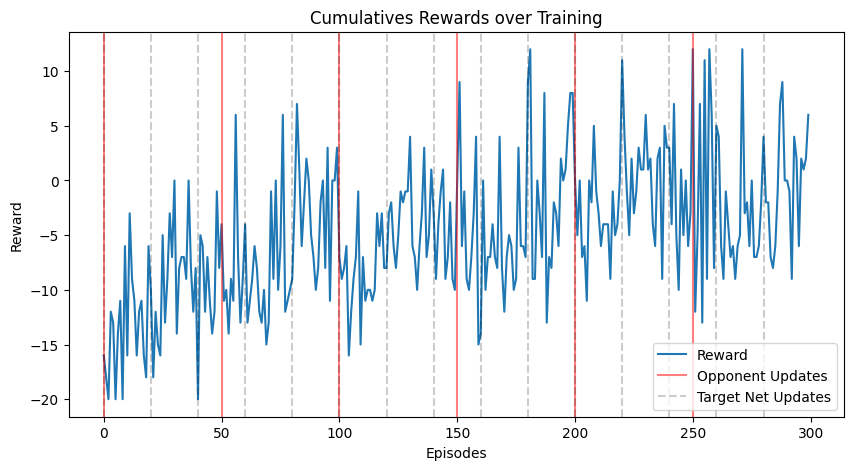

In [74]:
plt.figure(figsize=(10,5))
plt.plot(list_reward, label="Reward")
for i in range(0, len(list_reward), opponent_update_freq):
    if i == 0:
        plt.axvline(x=i, color='red', linestyle='-', alpha=0.5, label="Opponent Updates")
    else:
        plt.axvline(x=i, color='red', linestyle='-', alpha=0.5)

for i in range(0, len(list_reward), target_update_freq):
    if i == 0:
        plt.axvline(x=i, color='black', linestyle='--', alpha=0.2, label="Target Net Updates")
    else:
        plt.axvline(x=i, color='black', linestyle='--', alpha=0.2)
    
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Cumulatives Rewards over Training")
plt.legend()
plt.show()

### Evaluate

In [ ]:
def evaluate_DQN(name, num_episodes_eval=100):
    list_reward = []
    win_count = 0
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=True)
    env.reset()

    n_actions = env.action_space(controlled_agent).n
    obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)

    if name != 'random':
        checkpoint = torch.load(f"model_weights_DQN/{name}.pth", weights_only=False)

        policy_net = DuelingDQN(obs_shape, n_actions).to(device)
        policy_net.load_state_dict(checkpoint['model_state_dict'])
        
        list_reward_training = checkpoint['list_reward']
    
    for episode in tqdm(range(num_episodes_eval)):
        env.reset()
        total_reward = 0

        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
            
            if current_agent == controlled_agent:
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                if name == 'random':
                    action = random.choice(legal_moves)
                else:
                    action = select_action_dqn(policy_net, state, action_mask, device)
                
                env.step(action)
                reward = env.rewards[current_agent]
                total_reward += reward

            else:
                action = random.choice(legal_moves)
                env.step(action)
        
        list_reward.append(total_reward)
        if env.winner == 0: # controlled_agent ("player_0") gagne
            win_count += 1
        elif env.winner == -1: # match nul : on peut compter 0.5 victoire
            win_count += 0.5
    
    avg_reward = sum(list_reward)/len(list_reward)
    print(f"{num_episodes_eval} episodes => Avg Reward : {avg_reward} // Winrate : {win_count/num_episodes_eval}")
    
    env.close()
    return avg_reward

In [ ]:
avg_reward = evaluate_DQN('test2')
#89%

  1%|          | 1/100 [00:00<00:39,  2.51it/s]

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]

100 episodes => Avg Reward : -2.17 // Winrate : 0.89
